# **Importing Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve

import re
import string
import tqdm
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
lemma = WordNetLemmatizer()

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization,SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# **Load the Data set**



In [3]:
from google.colab import drive 
drive.mount('/content/gdriProject_Files')

Mounted at /content/gdriProject_Files


In [4]:
train = pd.read_csv('/content/gdriProject_Files/MyDrive/Project/train.csv')

test = pd.read_csv('/content/gdriProject_Files/MyDrive/Project/test.csv')

# **Check head and info of the data**

In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
#Data Info
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,7613.0,5441.934848,3137.11609,1.0,2734.0,5408.0,8146.0,10873.0
target,7613.0,0.429660,0.49506,0.0,0.0,0.0,1.0,1.0


# **Is there a missing data [how many and the precentage if there]?**

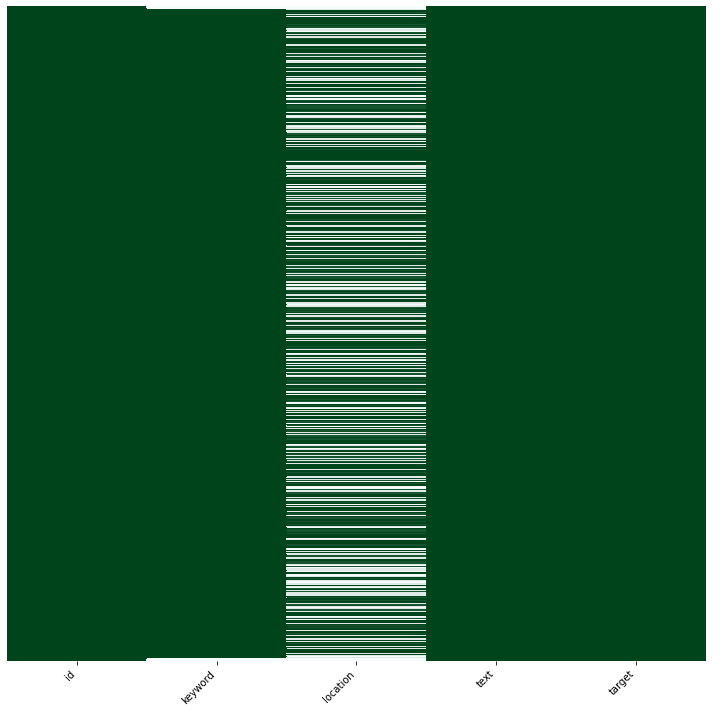

In [8]:
ax, fig = plt.subplots(figsize=(10,10))

ax = sns.heatmap(train.isna(),yticklabels=False,cbar=False,cmap='BuGn_r', alpha = 0.9)

plt.xticks(rotation = 45, ha="right")

plt.tight_layout()

In [9]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [10]:
percent_missing = train.isnull().sum() * 100 / len(train)
missing_value_train = pd.DataFrame({'column_name': train.columns,
                                 'percent_missing': percent_missing})

missing_value_train.sort_values('percent_missing', inplace=True)

percent_missing = train.isnull().sum() * 100 / len(train)

print(percent_missing)

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64


# **How many data in each class?**

In [11]:

diec = train.value_counts().reset_index().sum()
diec.columns=['#','id','keyword','location','text','target']

print(diec)

id                                                   27468132
keyword     ablazemudslidemudslidemudslidemudslidemudslide...
location    BirminghamChiswick, LondonEdinburghLondonThe P...
text        @bbcmtd Wholesale Markets ablaze http://t.co/l...
target                                                   2196
0                                                        5080
dtype: object


In [12]:
train['location'].value_counts().sum()

5080

In [13]:
train.shape

(7613, 5)

# **Get the top 15 locations of the data, Get the top 15 keyword in the data**

In [14]:
#The top 15 locations of the data ,  the top 15 keyword in the data

kw = train.keyword.value_counts().head(15).reset_index()
kw.columns=['keyword','frequency']
loc = train.location.value_counts().head(15).reset_index()
loc.columns=['location','frequency']


In [15]:
def plot_frequency(data,title):
    plt.figure(figsize=(15,6))
    plt.title('Top 15 '+title,fontsize=20,fontweight='bold', pad=20)
    sns.barplot(x=title,y='frequency',data=data,palette='Set2')

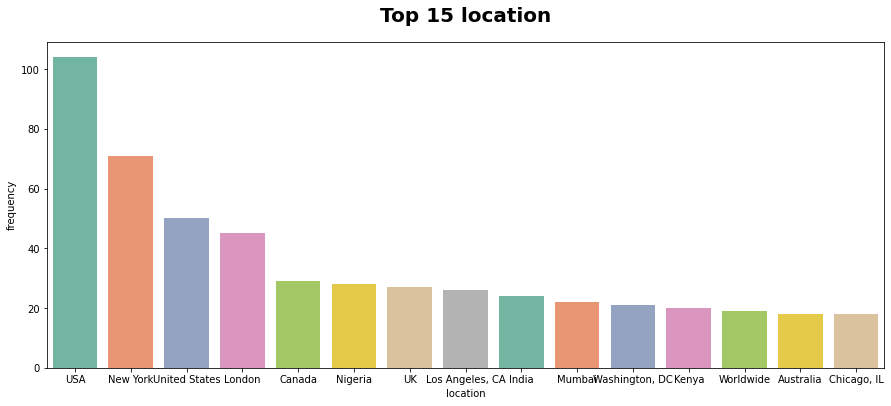

In [16]:
plot_frequency(loc,'location')

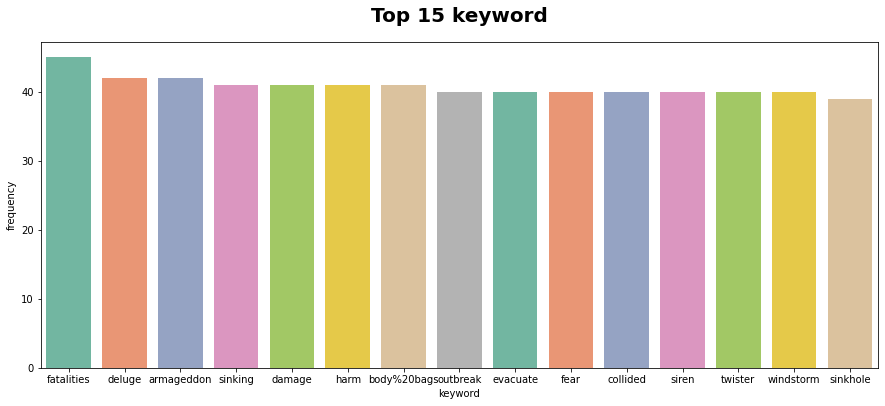

In [17]:
plot_frequency(kw,'keyword')

# **Data Cleaning**

**Natural Language Processing**

Behind the scenes, text pre-processing can be boiled down to these few simple steps:

**Tokenization** - The process of mapping sentences from character to strings and strings into words are initially the basic steps of any NLP problem because to understand any text or document we need to understand the meaning of the text by interpreting words/sentences present in the text. .

**Stopwords** - Throw away any words that occur too frequently as its frequency of occurrence will not be useful in helping detecting relevant texts.

**Stemming** - the process of reducing inflected (or sometimes derived) words to their word stem, base or root form - generally a written form of the word

**Vectorization** - Converting text into vector format. One of the simplest is the famous bag-of-words approach, where you create a matrix (for each document or text in the corpus). In the simplest form, this matrix stores word frequencies (word counts) and is oft referred to as vectorization of the raw text.

In [18]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [19]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def Remove_UC(string):
    thestring = re.sub(r'[^a-zA-Z\s]','', string)
    # remove word of length less than 2
    thestring = re.sub(r'\b\w{1,2}\b', '', thestring)
    #https://www.geeksforgeeks.org/python-remove-unwanted-spaces-from-string/
    return re.sub(' +', ' ', thestring) 

# Applying helper functions

train['clean_text'] = train['text'].apply(lambda x: remove_URL(x))
train['clean_text'] = train['clean_text'].apply(lambda x: remove_emoji(x))
train['clean_text'] = train['clean_text'].apply(lambda x: remove_html(x))
train['clean_text'] = train['clean_text'].apply(lambda x: remove_punct(x))
train['clean_text'] = train['clean_text'].apply(lambda x: Remove_UC(x))

In [20]:
# Tokenizing

train['tokenized'] = train['clean_text'].apply(word_tokenize)

In [21]:
train.head()

,id,keyword,location,text,target,clean_text,tokenized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason this earthquake May A...,"[Our, Deeds, are, the, Reason, this, earthquak..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near Ronge Sask Canada,"[Forest, fire, near, Ronge, Sask, Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked shelter place are being no...,"[All, residents, asked, shelter, place, are, b..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders Ca...,"[people, receive, wildfires, evacuation, order..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska smok...,"[Just, got, sent, this, photo, from, Ruby, Ala..."


In [22]:
train['lower'] = train['tokenized'].apply(
    lambda x: [word.lower() for word in x])

train['no_stopwords'] = train['lower'].apply(
    lambda x: [word for word in x if word not in set(nltk.corpus.stopwords.words('english'))])

In [23]:
train['no_stopwords'] = [' '.join(map(str, l)) for l in train['no_stopwords']]

In [24]:
train.head()

,id,keyword,location,text,target,clean_text,tokenized,lower,no_stopwords
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason this earthquake May A...,"[Our, Deeds, are, the, Reason, this, earthquak...","[our, deeds, are, the, reason, this, earthquak...",deeds reason earthquake may allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near Ronge Sask Canada,"[Forest, fire, near, Ronge, Sask, Canada]","[forest, fire, near, ronge, sask, canada]",forest fire near ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked shelter place are being no...,"[All, residents, asked, shelter, place, are, b...","[all, residents, asked, shelter, place, are, b...",residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders Ca...,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...",people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska smok...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...",got sent photo ruby alaska smoke wildfires pou...


In [25]:
test['clean_text'] = test['text'].apply(lambda x: remove_URL(x))
test['clean_text'] = test['clean_text'].apply(lambda x: remove_emoji(x))
test['clean_text'] = test['clean_text'].apply(lambda x: remove_html(x))
test['clean_text'] = test['clean_text'].apply(lambda x: remove_punct(x))
train['clean_text'] = train['clean_text'].apply(lambda x: Remove_UC(x))

test['tokenized'] = test['clean_text'].apply(word_tokenize)

test['lower'] = test['tokenized'].apply(
    lambda x: [word.lower() for word in x])

test['no_stopwords'] = test['lower'].apply(
    lambda x: [word for word in x if word not in set(nltk.corpus.stopwords.words('english'))])

test['no_stopwords'] = [' '.join(map(str, l)) for l in test['no_stopwords']]

In [26]:
combined = train['no_stopwords'].tolist() + test['no_stopwords'].tolist()

# **Word Cloud**
Keywords are interesting to consider as a way of identifying disaster. This is because some keywords really are only used in a certain context.

What do our keywords look like? We can output wordclouds for our train and test datasets to examine this.

In [27]:
import nltk
stopwords = nltk.corpus.stopwords.words('english')

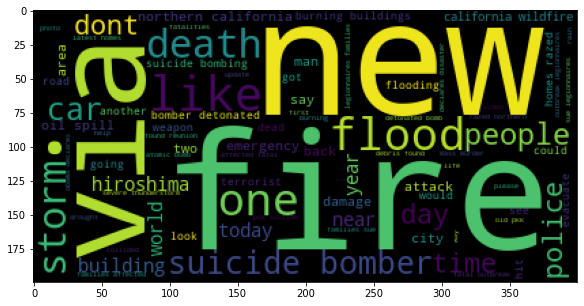

In [28]:
#Disaster tweets
from wordcloud import WordCloud
plt.figure(figsize=(10,5))
text = ' '.join(train.no_stopwords[train['target']==1])
wc = WordCloud(background_color='black',stopwords=stopwords).generate(text)
plt.imshow(wc)

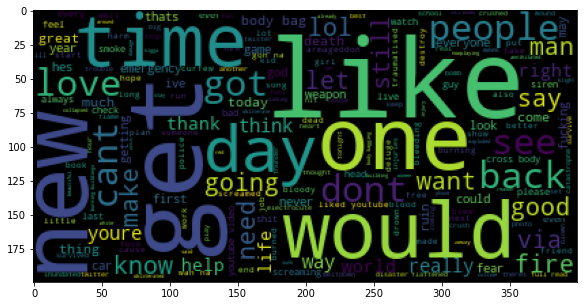

In [29]:
#Not Disaster tweets
from wordcloud import WordCloud
plt.figure(figsize=(10,5))
text = ' '.join(train.no_stopwords[train['target']==0])
wc = WordCloud(background_color='black',stopwords=stopwords).generate(text)
plt.imshow(wc)

# **Embedding**

In [30]:

# Load pretrained GloVe embeddings

embeddings_index = dict()
f = open('/content/gdriProject_Files/MyDrive/Project/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [31]:
#Creating Embeddings for the tweets

max_len_tweet = 50

tok = Tokenizer()
tok.fit_on_texts(combined)
vocab_size = len(tok.word_index) + 1
encoded_tweet = tok.texts_to_sequences(combined)
padded_tweet = pad_sequences(encoded_tweet, maxlen=max_len_tweet, padding='post')

vocab_size = len(tok.word_index) + 1

tweet_embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tok.word_index.items():
    t_embedding_vector = embeddings_index.get(word)
    if t_embedding_vector is not None:
        tweet_embedding_matrix[i] = t_embedding_vector

# **LSTM Network**

In [32]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [33]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_len_tweet, embeddings_initializer=Constant(tweet_embedding_matrix), trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.2))
model.add(BatchNormalization())
# model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
# model.add(BatchNormalization())
# model.add(LSTM(20,dropout=0.2, recurrent_dropout=0.2))
# model.add(Dropout(0.3))
#model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
optimzer=Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy', optimizer=optimzer, metrics=['accuracy', 'mae'])

In [34]:
max_words = 4000
max_len = 40
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(train)
sequences = tok.texts_to_sequences(train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [35]:
model.fit(padded_tweet[:7613], train['target'].values, epochs = 11)

Epoch 1/11
238/238 [==============================] - 35s 131ms/step - loss: 0.5626 - accuracy: 0.7352 - mae: 0.3805
Epoch 2/11
238/238 [==============================] - 31s 130ms/step - loss: 0.5020 - accuracy: 0.7725 - mae: 0.3283
Epoch 3/11
238/238 [==============================] - 31s 130ms/step - loss: 0.4908 - accuracy: 0.7772 - mae: 0.3182
Epoch 4/11
238/238 [==============================] - 31s 132ms/step - loss: 0.4860 - accuracy: 0.7793 - mae: 0.3154
Epoch 5/11
238/238 [==============================] - 32s 133ms/step - loss: 0.4834 - accuracy: 0.7812 - mae: 0.3128
Epoch 6/11
238/238 [==============================] - 32s 134ms/step - loss: 0.4803 - accuracy: 0.7767 - mae: 0.3118
Epoch 7/11
238/238 [==============================] - 31s 130ms/step - loss: 0.4788 - accuracy: 0.7865 - mae: 0.3095
Epoch 8/11
238/238 [==============================] - 31s 130ms/step - loss: 0.4730 - accuracy: 0.7839 - mae: 0.3067
Epoch 9/11
238/238 [==============================] - 31s 131ms/

In [36]:
test.head()

,id,keyword,location,text,clean_text,tokenized,lower,no_stopwords
0,0,NaN,NaN,Just happened a terrible car crash,Just happened a terrible car crash,"[Just, happened, a, terrible, car, crash]","[just, happened, a, terrible, car, crash]",happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",Heard about earthquake is different cities sta...,"[Heard, about, earthquake, is, different, citi...","[heard, about, earthquake, is, different, citi...",heard earthquake different cities stay safe ev...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...,"[there, is, a, forest, fire, at, spot, pond, g...","[there, is, a, forest, fire, at, spot, pond, g...",forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting Spokane wildfires,"[Apocalypse, lighting, Spokane, wildfires]","[apocalypse, lighting, spokane, wildfires]",apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan,"[Typhoon, Soudelor, kills, 28, in, China, and,...","[typhoon, soudelor, kills, 28, in, china, and,...",typhoon soudelor kills 28 china taiwan


***Prediction***

---



In [37]:
preds = model.predict(padded_tweet[7613:])

In [38]:
preds[:20]

array([[0.8119479 ],
       [0.56771547],
       [0.89873374],
       [0.7576249 ],
       [0.9841245 ],
       [0.657555  ],
       [0.1201956 ],
       [0.09103543],
       [0.08879551],
       [0.09542933],
       [0.13012832],
       [0.10026875],
       [0.0954273 ],
       [0.12603351],
       [0.10265157],
       [0.44558924],
       [0.12674084],
       [0.1846984 ],
       [0.12327209],
       [0.10017037]], dtype=float32)

In [39]:
# pred=[1 if i>0.5 else 0 for i in preds]
pred = np.round(preds).astype(int).reshape(3263)

In [40]:
pred

array([1, 1, 1, ..., 1, 1, 0])

In [41]:
submission=pd.DataFrame()
submission['id']=test['id'].to_list()
submission['target']=pred

In [42]:
submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0
